In [1]:
# Importing the required libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import json

In [2]:
tf.__version__

'2.6.2'

In [3]:
data_directory = '../input/sign-language-gesture-images-dataset/Gesture Image Pre-Processed Data'
Characters = sorted(os.listdir(data_directory))
mapping = dict(zip(list(range(len(Characters))),Characters))

In [4]:
output = [json.dumps(mapping)]
output = '\n'.join(output)
file = open('mapping.json', 'w')
file.write(output)
file.close()

In [5]:
# Importing images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.25,
                                   rotation_range = 5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_dataset = train_datagen.flow_from_directory(directory = data_directory,
                                                  target_size = (50,50),
                                                  class_mode = 'categorical',
                                                  subset = 'training',
                                                  batch_size = 32)

Found 41625 images belonging to 37 classes.


In [6]:
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.25)

valid_dataset = valid_datagen.flow_from_directory(directory = data_directory,
                                                  target_size = (50,50),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 13875 images belonging to 37 classes.


In [8]:
# Loading the pretrained DenseNet201 network 
pretrained_model = tf.keras.applications.DenseNet201(input_shape=(50,50,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model.trainable = False

In [9]:
# Building the model
model = tf.keras.models.Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(Characters),activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
# Fitting the model on the dataset
history = model.fit(x=train_dataset, validation_data=valid_dataset, epochs=20)

Epoch 1/20
1301/1301 [==============================] - 446s 343ms/step - loss: 1.9779 - accuracy: 0.4297 - val_loss: 0.5704 - val_accuracy: 0.8779
Epoch 2/20
1301/1301 [==============================] - 411s 316ms/step - loss: 1.1048 - accuracy: 0.6477 - val_loss: 0.3626 - val_accuracy: 0.8978
Epoch 3/20
1301/1301 [==============================] - 432s 332ms/step - loss: 0.9097 - accuracy: 0.7102 - val_loss: 0.2904 - val_accuracy: 0.9248
Epoch 4/20
1301/1301 [==============================] - 418s 321ms/step - loss: 0.8216 - accuracy: 0.7393 - val_loss: 0.2413 - val_accuracy: 0.9321
Epoch 5/20
1301/1301 [==============================] - 417s 320ms/step - loss: 0.7699 - accuracy: 0.7550 - val_loss: 0.2256 - val_accuracy: 0.9359
Epoch 6/20
1301/1301 [==============================] - 423s 325ms/step - loss: 0.7189 - accuracy: 0.7712 - val_loss: 0.2032 - val_accuracy: 0.9456
Epoch 7/20
1301/1301 [==============================] - 429s 329ms/step - loss: 0.6839 - accuracy: 0.7836 - val_

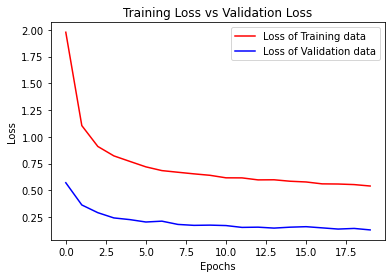

In [14]:
# Training dataset loss VS Validation dataset loss
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(train_loss))
plt.title('Training Loss vs Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.show()

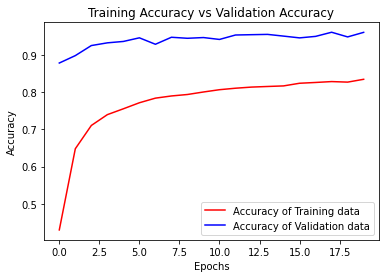

In [15]:
# Training dataset accuracy VS Validation dataset accuracy
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(len(train_accuracy))
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Accuracy of Training data')
plt.plot(epochs, validation_accuracy, 'b', label='Accuracy of Validation data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()

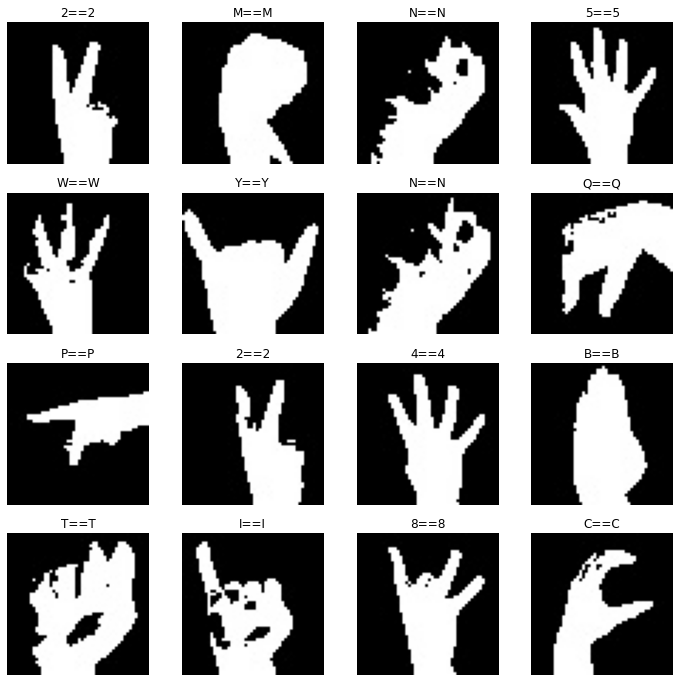

In [18]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    r=i//4
    c=i%4
    image = valid_dataset[0][0][i]
    ax=axs[r][c].axis("off")
    actual=mapping[np.where(valid_dataset[0][1][i]==1.0)[0][0]]
    image1 = img_to_array(image)
    image1 = np.expand_dims(image1, axis = 0)
    pred = model.predict(image1)
    predict=mapping[np.argmax(pred)]
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(image)
plt.show()

In [19]:
# Saving the model
model.save('sign-language-recognition.h5')